<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Feature_selection_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 16 16:04:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import seaborn as sns

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# memory management
import gc
import re
import timeit #pour mesurer le temps déxécution
#permet de stocker notre modéle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# modeling 
import lightgbm as lgb
import sklearn.metrics as me
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV 
#pour avoir le tableau f1,precision
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import precision_score,recall_score,accuracy_score
from sklearn.metrics import classification_report

In [ ]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list  

In [ ]:
train= pd.read_csv('/content/drive/MyDrive/p7/data/data_train.csv')

In [ ]:
train.shape

(307507, 897)

In [ ]:
train[train['TARGET'].notnull()]

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_NEW_INSTALLMENTS_PER_LOAN_MIN,CC_NEW_INSTALLMENTS_PER_LOAN_MAX,CC_NEW_INSTALLMENTS_PER_LOAN_MEAN,CC_NEW_INSTALLMENTS_PER_LOAN_SUM,CC_NEW_INSTALLMENTS_PER_LOAN_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,0.018801,...,0.0,0.0,0.0,0.0,51.0,51.0,51.0,4743.0,0.0,93.0
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,0.003541,...,0.0,0.0,0.0,0.0,78.0,78.0,78.0,6942.0,0.0,89.0
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,0.010032,...,0.0,0.0,0.0,0.0,80.0,80.0,80.0,7680.0,0.0,96.0
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,0.008019,...,0.0,0.0,0.0,0.0,9.0,9.0,9.0,117.0,0.0,13.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0,0,0,1,0,157500.0,254700.0,27558.0,0.032561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307503,456252,0,1,0,0,0,72000.0,269550.0,12001.5,0.025164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307504,456253,0,1,0,0,0,153000.0,677664.0,29979.0,0.005002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307505,456254,1,1,0,0,0,171000.0,370107.0,20205.0,0.005313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# data missing values (in percent)
data_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
data_missing.head()

CLOSED_NEW_FLAG_1_MEAN_MEAN        1.0
CLOSED_MONTHS_BALANCE_SIZE_MEAN    1.0
BURO_STATUS_3_MEAN_MEAN            1.0
BURO_STATUS_2_MEAN_MEAN            1.0
BURO_STATUS_1_MEAN_MEAN            1.0
dtype: float64

In [ ]:
# Identify missing values above threshold
data_missing = data_missing.index[data_missing > 0.75]

print('There are %d columns with more than 75%% missing values' % len(data_missing))

There are 300 columns with more than 75% missing values


In [ ]:
data = train.drop(columns = data_missing)

print('data set full shape: ', data.shape)

data set full shape:  (307507, 597)


## **LightGBM model** 

https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection

In [ ]:
data.head(2)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,0.018801,...,32428.11750,194568.705,32426.28,32428.485,32428.11750,194568.705,-68.0,-123.333333,-740.0,6.0
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,0.003541,...,6493.32875,233759.835,2705.76,19978.695,6493.32875,233759.835,-680.0,-1755.055556,-63182.0,36.0


https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python

In [ ]:
cor_matrix = data.corr().abs()
print(cor_matrix)

                                SK_ID_CURR    TARGET  CODE_GENDER  \
SK_ID_CURR                        1.000000  0.002111     0.000735   
TARGET                            0.002111  1.000000     0.054710   
CODE_GENDER                       0.000735  0.054710     1.000000   
FLAG_OWN_CAR                      0.001215  0.021850     0.345848   
FLAG_OWN_REALTY                   0.000710  0.006146     0.044374   
...                                    ...       ...          ...   
INSTAL_AMT_PAYMENT_SUM            0.000953  0.002216     0.000668   
INSTAL_DAYS_ENTRY_PAYMENT_MAX     0.000156  0.001218     0.000997   
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0.000520  0.001178     0.000768   
INSTAL_DAYS_ENTRY_PAYMENT_SUM     0.000665  0.000100     0.001128   
INSTAL_COUNT                      0.000126  0.000335     0.001322   

                                FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                          0.001215         0.000710      0.001120   
TARGET       

In [ ]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

                                SK_ID_CURR    TARGET  CODE_GENDER  \
SK_ID_CURR                             NaN  0.002111     0.000735   
TARGET                                 NaN       NaN     0.054710   
CODE_GENDER                            NaN       NaN          NaN   
FLAG_OWN_CAR                           NaN       NaN          NaN   
FLAG_OWN_REALTY                        NaN       NaN          NaN   
...                                    ...       ...          ...   
INSTAL_AMT_PAYMENT_SUM                 NaN       NaN          NaN   
INSTAL_DAYS_ENTRY_PAYMENT_MAX          NaN       NaN          NaN   
INSTAL_DAYS_ENTRY_PAYMENT_MEAN         NaN       NaN          NaN   
INSTAL_DAYS_ENTRY_PAYMENT_SUM          NaN       NaN          NaN   
INSTAL_COUNT                           NaN       NaN          NaN   

                                FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                          0.001215         0.000710      0.001120   
TARGET       

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print('There are %d columns to remove.' % (len(to_drop)))

In [ ]:
data = data.drop(columns = to_drop)
print('Data shape: ', data.shape)

Data shape:  (307507, 501)


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/p7/data/data_test.csv')

In [ ]:
# remove all the columns which are not in app_train
filter_columns = list(data.columns)

def remove_columns(dataframe, filter_columns):
    """dataframe : dataframe to filter
    filter_columns : columns to keep"""
    new = pd.DataFrame()

    for column in filter_columns:
        try:
            new[column] = dataframe[column]
        except:
            print('...colonne non présente : ', column)
            print('\n')
    print("All selected columns have been kept from the dataset")
    return new

In [ ]:
test = remove_columns(test, filter_columns)

...colonne non présente :  TARGET


All selected columns have been kept from the dataset


In [ ]:
test.shape

(48744, 500)

In [ ]:
import pickle
pickle.dump(test, open('content/drive/MyDrive/p7/test.sav', 'wb'))

In [ ]:
train.to_csv('/content/drive/MyDrive/p7/data/Df_train.csv', index=False)
test.to_csv('/content/drive/MyDrive/p7/data/Df_test.csv', index=False)

**Modeling on imputation with keeping zero importance feature values**

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/p7/data/Df_train.csv')

**Imputation**

In [ ]:
# data missing values (in percent)
data_missing = (data.isnull().sum() / len(data)).sort_values(ascending = False)
data_missing.head()

COMMONAREA_AVG                0.698722
NONLIVINGAPARTMENTS_AVG       0.694332
LIVINGAPARTMENTS_AVG          0.683552
FLOORSMIN_AVG                 0.678489
BURO_NEW_EARLY_CLOSED_MEAN    0.667354
dtype: float64

In [ ]:
# Identify missing values above threshold
data_missing = data_missing.index[data_missing > 0.5]

print('There are %d columns with more than 50%% missing values' % len(data_missing))

There are 25 columns with more than 50% missing values


In [ ]:
data_clean = data.drop(columns = data_missing)

print('data_clean set full shape: ', data_clean.shape)

data_clean set full shape:  (307507, 476)


In [ ]:
data_clean.isnull().sum().sort_values(ascending=False)

CLOSED_CREDIT_DAY_OVERDUE_MAX     153542
CLOSED_DAYS_CREDIT_ENDDATE_MIN    153542
CLOSED_DAYS_CREDIT_MAX            153542
CLOSED_MONTHS_BALANCE_SIZE_SUM    153542
CLOSED_CNT_CREDIT_PROLONG_SUM     153542
                                   ...  
ORGANIZATION_TYPE_Hotel                0
ORGANIZATION_TYPE_Government           0
ORGANIZATION_TYPE_Emergency            0
ORGANIZATION_TYPE_Electricity          0
SK_ID_CURR                             0
Length: 476, dtype: int64

In [ ]:
data_clean[data_clean==np.inf]=np.nan

In [ ]:
# Imputaion with mod & median
def filling_nan_value(df):
  column_with_nan = df.columns[df.isnull().any()]
  for column in column_with_nan:
    df[column]= df[column].fillna(df[column].median())
  return (df)

In [ ]:
data_clean = filling_nan_value(data_clean)

In [ ]:
data_clean.isnull().sum().sort_values(ascending=False).head()

SK_ID_CURR                                  0
PREV_NEW_WEEKDAY_COS_MEDIAN                 0
PREV_NAME_PAYMENT_TYPE_Construction_MEAN    0
PREV_NAME_PAYMENT_TYPE_Connectivity_MEAN    0
PREV_NAME_PAYMENT_TYPE_Clothing_MEAN        0
dtype: int64

In [ ]:
gc.enable()
del data 
gc.collect()

14470

In [ ]:
data_clean.shape

(307507, 476)

**Spliting**

In [ ]:
X= data_clean.drop(['TARGET','SK_ID_CURR'],axis=1).copy()
y = data_clean['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size = 0.2,random_state= 0)
print('The shape of X_train is', X_train.shape)
print('The shape of X_test is', X_test.shape)
print('The shape of y_train is', y_train.shape)
print('The shape of y_test is', y_test.shape)

The shape of X_train is (246005, 474)
The shape of X_test is (61502, 474)
The shape of y_train is (246005,)
The shape of y_test is (61502,)


In [ ]:
del X,y
gc.collect()

150

In [ ]:
X_train.head(3)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
239193,1,1,1,0,436500.0,3150000.0,79632.0,0.025164,-12932,-2569.0,...,0.0,0.0,36485.3925,12741.783438,335915.37,2290.95,-65.0,-805.692308,-21295.0,25.0
268315,1,0,0,0,337500.0,760122.0,21033.0,0.010032,-16486,-711.0,...,0.0,0.0,36485.3925,12741.783438,335915.37,2290.95,-65.0,-805.692308,-21295.0,25.0
281929,1,0,0,0,85500.0,315000.0,12006.0,0.028663,-18366,-6730.0,...,0.0,0.0,36485.3925,12741.783438,335915.37,2290.95,-65.0,-805.692308,-21295.0,25.0


In [ ]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X_train.shape[1])

# Create the model with several hyperparameters
clf_LGBM = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [ ]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Train using early stopping
    clf_LGBM.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += clf_LGBM.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.537443	valid_0's auc: 0.759136
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.559883	valid_0's auc: 0.762389
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.537443	valid_0's auc: 0.759136
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.559883	valid_0's auc: 0.762389


In [ ]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head(5)

,feature,importance
67,NEW_ANNUITY_CREDIT_RATIO,347.0
68,NEW_EXT_MEAN,127.0
8,DAYS_BIRTH,108.0
26,EXT_SOURCE_3,105.0
9,DAYS_EMPLOYED,93.0


In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(10)

There are 147 features with 0.0 importance


,feature,importance
198,NEW_RENT_EXPENSE_nan,0.0
199,NEW_HAS_COMPANY_nan,0.0
72,NAME_CONTRACT_TYPE_nan,0.0
201,NEW_LABORERS_nan,0.0
203,NEW_AGE_SEGMENT_OLD,0.0
204,NEW_AGE_SEGMENT_YOUNG,0.0
205,NEW_AGE_SEGMENT_nan,0.0
70,NEW_DEF_30&60_SOCIAL_CIRCLE,0.0
214,BURO_CREDIT_DAY_OVERDUE_MEAN,0.0
237,BURO_CREDIT_TYPE_Microloan_MEAN,0.0


We see that one of our features made it into the top 10 most important! That's a good sign for all of our hard work making the features. It also looks like many of the features we made have literally 0 importance. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we can remove these features from the model with no effect on performance (except for faster training).

In [ ]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """

    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
        # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

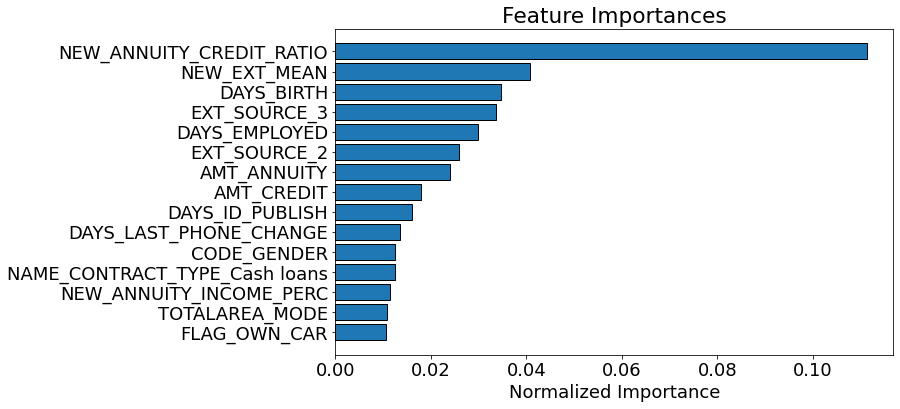

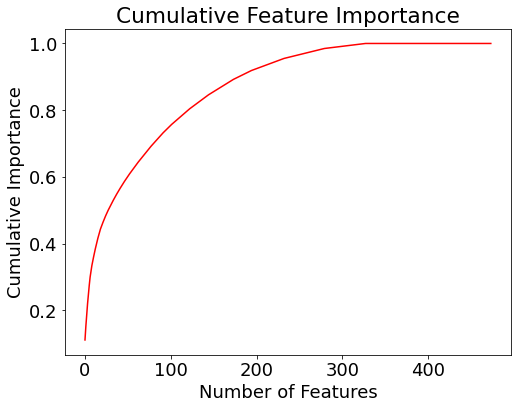

181 features required for 0.90 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

**Model Prediction with imputation & zero feature**

In [ ]:
clf_LGBM.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 200)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.537443	valid_0's auc: 0.759136
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.559883	valid_0's auc: 0.762389


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_test,y_test)

DummyClassifier(strategy='most_frequent')

In [ ]:
y_pred_dum=dummy_clf.predict(X_test)
AUROC_dum=roc_auc_score(y_test, y_pred_dum)
#on va le comparer avec notre scorer
AUROC_dum

0.5

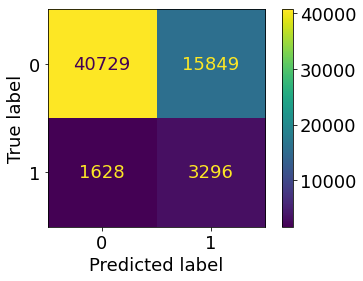

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_LGBM, X_test, y_test)

In [ ]:
from sklearn import model_selection 
from sklearn.model_selection import KFold
# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [ ]:
test_predictions = clf_LGBM.predict_proba(X_test, num_iteration = 10)[:, 1] / k_fold.n_splits

In [ ]:
AUROC_LGBM=roc_auc_score(y_test, test_predictions)
AUROC_LGBM

0.7415078739776485

In [ ]:
y_predX= clf_LGBM.predict(X_test)

In [ ]:
precision_LGBM = accuracy_score(y_test, y_predX)
precision_LGBM

0.7158303794998536

In [ ]:
rappel_LGBM = recall_score(y_test, y_predX)
rappel_LGBM

0.669374492282697

,thr,tpr,fpr
0,1.940925,0.000000,0.000000
1,0.940925,0.000000,0.000018
2,0.934333,0.000609,0.000018
3,0.930848,0.000609,0.000035
4,0.929041,0.001422,0.000035
...,...,...,...
8281,0.067730,0.999594,0.993920
8282,0.067723,0.999797,0.993920
8283,0.050260,0.999797,0.998851
8284,0.050161,1.000000,0.998851


AUC : 0.762389475960938


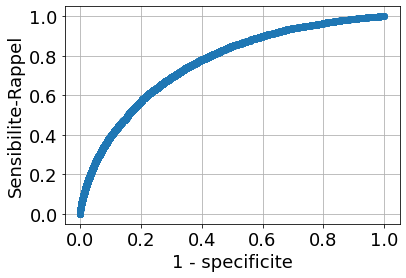

In [ ]:
from sklearn.metrics import roc_auc_score
[fpr, tpr, thr]  = me.roc_curve(y_test, clf_LGBM.predict_proba(X_test)[:, 1])
#1-fpr correspond a la antispecifite pour la vrais specifite 1-valeur
#tpr le rappel , sensibilité
#thr le seuil 

df_roc = pd.DataFrame({'thr': thr, 'tpr': tpr, 'fpr': fpr})
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1 - specificite')
plt.ylabel('Sensibilite-Rappel')
plt.grid()
display(df_roc)
#ceci est notre AUROC qui permet de comparer 
#AUROC_LGBM=roc_auc_score(y_test, clf_LGBM.predict_proba(X_test)[:, 1])

print('AUC : {}'.format(roc_auc_score(y_test, clf_LGBM.predict_proba(X_test)[:, 1])))

In [ ]:
# indice du premier seuil pour lequel
#Taux de faux négatifs + taux de vrais positifs (sensibilité=rappel)=1
#on pose taux de faux negatifs =0.05 (5%)
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensitivity : {:.2f}".format(tpr[idx]))
print("Specificity : {:.2f}".format(1-fpr[idx]))
print("Threshold : {:.2f}".format(thr[idx]))

Sensitivity : 0.95
Specificity : 0.26
Threshold : 0.23


In [ ]:
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

In [ ]:
f1_score_Lgbm = fbeta_score(y_test, y_predX, beta=1)
f5_score_Lgbm = fbeta_score(y_test, y_predX, beta=5)
f10_score_Lgbm = fbeta_score(y_test, y_predX, beta=10)

In [ ]:
print('f1 score:',f1_score_Lgbm)
print('f5 score:',f5_score_Lgbm)
print('f10 score:',f10_score_Lgbm)

f1 score: 0.2738792637832897
f5 score: 0.6024535133045099
f10 score: 0.6507658172790274


In [ ]:
resultat111=pd.DataFrame({ 'Model': ['LightGBM_with_imputation & 0F'], 'f1': [f1_score_Lgbm*100], 'f5': [f5_score_Lgbm*100], 'f10': [f10_score_Lgbm*100],
                      'AUROC':[AUROC_LGBM*100],'Precision':[precision_LGBM*100],'Recall':[rappel_LGBM*100]})

In [ ]:
resultat111

,Model,f1,f5,f10,AUROC,Precision,Recall
0,LightGBM_with_imputation & 0F,27.387926,60.245351,65.076582,74.150787,71.583038,66.937449


In [ ]:
resultat111.to_csv('/content/drive/MyDrive/p7/data/result_LightGBM_with_imput_0F.csv', index=False)

**With imputation & without zero feature**

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/p7/data/Df_data.csv')

**Imputation**

In [ ]:
# data missing values (in percent)
data_missing = (data.isnull().sum() / len(data)).sort_values(ascending = False)
data_missing.head()

COMMONAREA_AVG                0.698722
NONLIVINGAPARTMENTS_AVG       0.694332
LIVINGAPARTMENTS_AVG          0.683552
FLOORSMIN_AVG                 0.678489
BURO_NEW_EARLY_CLOSED_MEAN    0.667354
dtype: float64

In [ ]:
# Identify missing values above threshold
data_missing = data_missing.index[data_missing > 0.5]

print('There are %d columns with more than 50%% missing values' % len(data_missing))

There are 25 columns with more than 50% missing values


In [ ]:
data_clean = data.drop(columns = data_missing)

print('data_clean set full shape: ', data_clean.shape)

data_clean set full shape:  (307507, 476)


In [ ]:
data_clean.isnull().sum().sort_values(ascending=False)

CLOSED_CREDIT_DAY_OVERDUE_MAX     153542
CLOSED_DAYS_CREDIT_ENDDATE_MIN    153542
CLOSED_DAYS_CREDIT_MAX            153542
CLOSED_MONTHS_BALANCE_SIZE_SUM    153542
CLOSED_CNT_CREDIT_PROLONG_SUM     153542
                                   ...  
ORGANIZATION_TYPE_Hotel                0
ORGANIZATION_TYPE_Government           0
ORGANIZATION_TYPE_Emergency            0
ORGANIZATION_TYPE_Electricity          0
SK_ID_CURR                             0
Length: 476, dtype: int64

In [ ]:
data_clean[data_clean==np.inf]=np.nan

In [ ]:
# Imputaion with mod & median
def filling_nan_value(df):
  column_with_nan = df.columns[df.isnull().any()]
  for column in column_with_nan:
    df[column]= df[column].fillna(df[column].median())
  return (df)

In [ ]:
data_clean = filling_nan_value(data_clean)

In [ ]:
data_clean.isnull().sum().sort_values(ascending=False).head()

SK_ID_CURR                                  0
PREV_NEW_WEEKDAY_COS_MEDIAN                 0
PREV_NAME_PAYMENT_TYPE_Construction_MEAN    0
PREV_NAME_PAYMENT_TYPE_Connectivity_MEAN    0
PREV_NAME_PAYMENT_TYPE_Clothing_MEAN        0
dtype: int64

In [ ]:
gc.enable()
del data 
gc.collect()

15047

In [ ]:
data_clean.shape

(307507, 476)

**Spliting**

In [ ]:
X= data_clean.drop(['TARGET'],axis=1).copy()
y = data_clean['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size = 0.2,random_state= 0)
print('The shape of X_train is', X_train.shape)
print('The shape of X_test is', X_test.shape)
print('The shape of y_train is', y_train.shape)
print('The shape of y_test is', y_test.shape)

The shape of X_train is (246005, 475)
The shape of X_test is (61502, 475)
The shape of y_train is (246005,)
The shape of y_test is (61502,)


In [ ]:
del X,y
gc.collect()

437

In [ ]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X_train.shape[1])

# Create the model with several hyperparameters
clf_LGBM = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [ ]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Train using early stopping
    clf_LGBM.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += clf_LGBM.feature_importances_

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.562243	valid_0's auc: 0.761321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.562243	valid_0's auc: 0.761321


In [ ]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head(10)

,feature,importance
68,NEW_ANNUITY_CREDIT_RATIO,321.0
69,NEW_EXT_MEAN,132.0
9,DAYS_BIRTH,104.0
27,EXT_SOURCE_3,101.0
10,DAYS_EMPLOYED,81.0
26,EXT_SOURCE_2,73.0
7,AMT_ANNUITY,66.0
6,AMT_CREDIT,53.0
12,DAYS_ID_PUBLISH,44.0
67,NEW_ANNUITY_INCOME_PERC,40.0


In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(10)

There are 141 features with 0.0 importance


,feature,importance
145,ORGANIZATION_TYPE_Industry: type 4,0.0
144,ORGANIZATION_TYPE_Industry: type 3,0.0
143,ORGANIZATION_TYPE_Industry: type 2,0.0
142,ORGANIZATION_TYPE_Industry: type 13,0.0
141,ORGANIZATION_TYPE_Industry: type 12,0.0
140,ORGANIZATION_TYPE_Industry: type 11,0.0
139,ORGANIZATION_TYPE_Industry: type 10,0.0
138,ORGANIZATION_TYPE_Industry: type 1,0.0
137,ORGANIZATION_TYPE_Housing,0.0
53,FLAG_DOCUMENT_20,0.0


We see that one of our features made it into the top 10 most important! That's a good sign for all of our hard work making the features. It also looks like many of the features we made have literally 0 importance. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we can remove these features from the model with no effect on performance (except for faster training).

In [ ]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """

    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
        # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

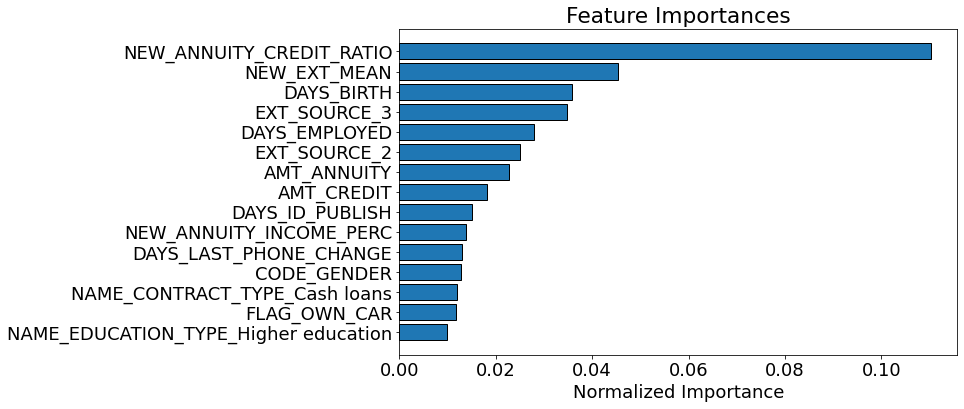

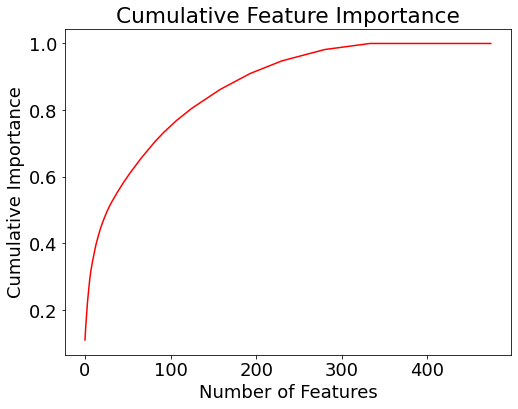

187 features required for 0.90 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

Let's remove the features that have zero importance.

In [ ]:
X_train = X_train.drop(columns = zero_features)
X_test = X_test.drop(columns = zero_features)

print('Training shape: ', X_train.shape)
print('Testing shape: ', X_test.shape)

Training shape:  (246005, 334)
Testing shape:  (61502, 334)


At this point, we can re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our own form of recursive feature elimination. Since we are repeating work, we should probably put the zero feature importance identification code in a function.

In [ ]:
def identify_zero_importance_features(X, y, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    x_train : dataframe
        Training features
        
    x_test : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X_train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Train using early stopping
        model.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 200)
        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations

            
    feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [ ]:
second_round_zero_features, feature_importances = identify_zero_importance_features(X_train, y_train)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.537063	valid_0's auc: 0.760036
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.556899	valid_0's auc: 0.76154
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.537063	valid_0's auc: 0.760036
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.556899	valid_0's auc: 0.76154

There are 26 features with 0.0 importance


There are now no 0 importance features left (I guess we should have expected this). If we want to remove more features, we will have to start with features that have a non-zero importance. One way we could do this is by retaining enough features to account for a threshold percentage of importance, such as 95%. At this point, let's keep enough features to account for 95% of the importance. Again, this is an arbitrary decision!

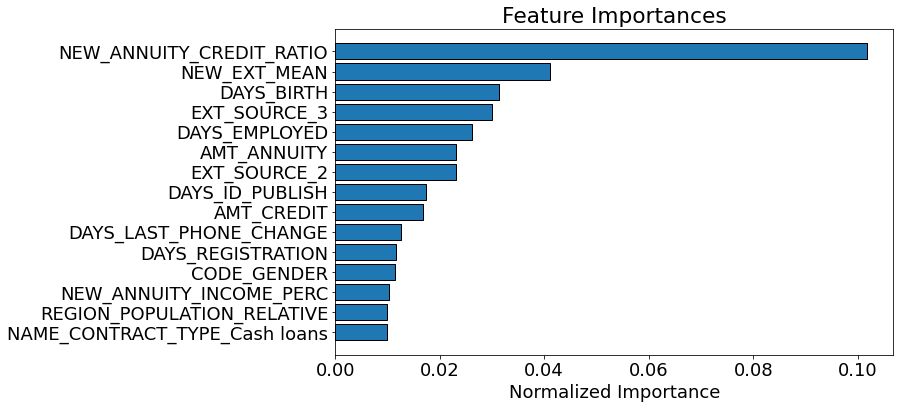

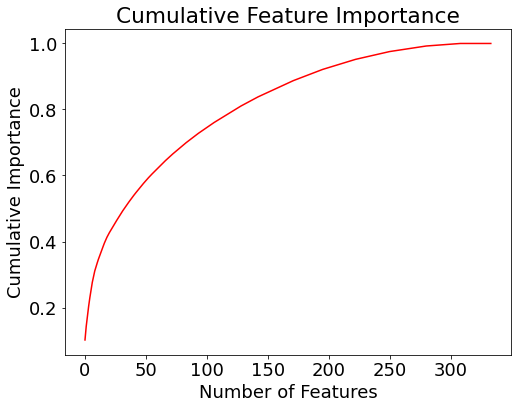

222 features required for 0.95 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

We can keep only the features needed for 95% importance. This step seems to me to have the greatest chance of harming the model's learning ability, so rather than changing the original dataset, we will make smaller copies. Then, we can test both versions of the data to see if the extra feature removal step is worthwhile.

https://www.kaggle.com/prashant111/lightgbm-classifier-in-python

**Model Prediction without zero feature**

In [ ]:
clf_LGBM.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 200)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.537063	valid_0's auc: 0.760036
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.556899	valid_0's auc: 0.76154


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_test,y_test)

DummyClassifier(strategy='most_frequent')

In [ ]:
y_pred_dum=dummy_clf.predict(X_test)
AUROC_dum=roc_auc_score(y_test, y_pred_dum)
#on va le comparer avec notre scorer
AUROC_dum

0.5

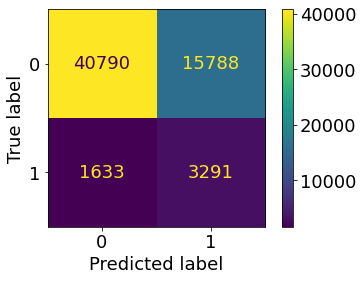

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_LGBM, X_test, y_test) 

In [ ]:
from sklearn import model_selection 
from sklearn.model_selection import KFold
# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [ ]:
test_predictions = clf_LGBM.predict_proba(X_test, num_iteration = 10)[:, 1] / k_fold.n_splits

In [ ]:
AUROC_LGBM=roc_auc_score(y_test, test_predictions)
AUROC_LGBM

0.7415078739776485

In [ ]:
y_predX= clf_LGBM.predict(X_test)

In [ ]:
precision_LGBM = accuracy_score(y_test, y_predX)
precision_LGBM

0.7167409189945042

In [ ]:
rappel_LGBM = recall_score(y_test, y_predX)
rappel_LGBM

0.6683590576766856

,thr,tpr,fpr
0,1.948585,0.000000,0.000000
1,0.948585,0.000000,0.000018
2,0.936765,0.000203,0.000018
3,0.936554,0.000203,0.000035
4,0.935683,0.000406,0.000035
...,...,...,...
8313,0.070230,0.999594,0.990933
8314,0.070225,0.999797,0.990933
8315,0.063895,0.999797,0.994114
8316,0.063763,1.000000,0.994114


AUC : 0.7615403932987246


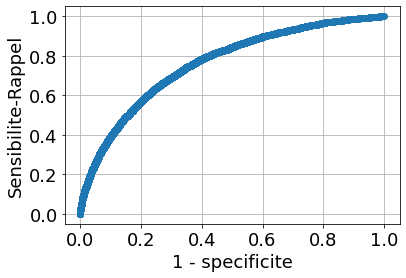

In [ ]:
from sklearn.metrics import roc_auc_score
[fpr, tpr, thr]  = me.roc_curve(y_test, clf_LGBM.predict_proba(X_test)[:, 1])
#1-fpr correspond a la antispecifite pour la vrais specifite 1-valeur
#tpr le rappel , sensibilité
#thr le seuil 

df_roc = pd.DataFrame({'thr': thr, 'tpr': tpr, 'fpr': fpr})
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1 - specificite')
plt.ylabel('Sensibilite-Rappel')
plt.grid()
display(df_roc)
#ceci est notre AUROC qui permet de comparer 
#AUROC_LGBM=roc_auc_score(y_test, clf_LGBM.predict_proba(X_test)[:, 1])

print('AUC : {}'.format(roc_auc_score(y_test, clf_LGBM.predict_proba(X_test)[:, 1])))

In [ ]:
# indice du premier seuil pour lequel
#Taux de faux négatifs + taux de vrais positifs (sensibilité=rappel)=1
#on pose taux de faux negatifs =0.05 (5%)
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensitivity : {:.2f}".format(tpr[idx]))
print("Specificity : {:.2f}".format(1-fpr[idx]))
print("Threshold : {:.2f}".format(thr[idx]))

Sensitivity : 0.95
Specificity : 0.25
Threshold : 0.22


In [ ]:
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

In [ ]:
f1_score_Lgbm = fbeta_score(y_test, y_predX, beta=1)
f5_score_Lgbm = fbeta_score(y_test, y_predX, beta=5)
f10_score_Lgbm = fbeta_score(y_test, y_predX, beta=10)

In [ ]:
print('f1 score:',f1_score_Lgbm)
print('f5 score:',f5_score_Lgbm)
print('f10 score:',f10_score_Lgbm)

f1 score: 0.27421572303462066
f5 score: 0.6018188340050218
f10 score: 0.6498624576962103


In [ ]:
resultat1111=pd.DataFrame({'Model': ['LightGBM_with_impute_without_0F'], 'f1': [f1_score_Lgbm*100], 'f5': [f5_score_Lgbm*100], 'f10': [f10_score_Lgbm*100],
                      'AUROC':[AUROC_LGBM*100],'Precision':[precision_LGBM*100],'Recall':[rappel_LGBM*100]})

In [ ]:
resultat1111

,Model,f1,f5,f10,AUROC,Precision,Recall
0,LightGBM_with_impute_without_0F,27.421572,60.181883,64.986246,74.150787,71.674092,66.835906


In [ ]:
resultat1111.to_csv('/content/drive/MyDrive/p7/data/LightGBM_w_impute_without_0F.csv', index=False)

**Modeling on *raw dataset* and with keeping *zero feature importance* values**


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/p7/data/Df_data.csv')

In [ ]:
data.head(2)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,0.018801,...,0.0,0.0,32428.485,32428.11750,194568.705,32426.28,-68.0,-123.333333,-740.0,6.0
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,0.003541,...,0.0,0.0,19978.695,6493.32875,233759.835,2705.76,-680.0,-1755.055556,-63182.0,36.0


**Spliting**

In [ ]:
X= data.drop(['TARGET','SK_ID_CURR'],axis=1).copy()
y = data['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size = 0.2,random_state= 0)
print('The shape of X_train is', X_train.shape)
print('The shape of X_test is', X_test.shape)
print('The shape of y_train is', y_train.shape)
print('The shape of y_test is', y_test.shape)

The shape of X_train is (246005, 499)
The shape of X_test is (61502, 499)
The shape of y_train is (246005,)
The shape of y_test is (61502,)


In [ ]:
del X,y
gc.collect()

602

In [ ]:
print(' X_train shape is :',X_train.shape)
print('y_train shape is: ', X_test.shape)

 X_train shape is : (246005, 499)
y_train shape is:  (61502, 499)


In [ ]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X_train.shape[1])

# Create the model with several hyperparameters
clf_LGBM = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [ ]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Train using early stopping
    clf_LGBM.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += clf_LGBM.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.53358	valid_0's auc: 0.764853
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.554379	valid_0's auc: 0.765908
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.53358	valid_0's auc: 0.764853
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.554379	valid_0's auc: 0.765908


In [ ]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head(10)

,feature,importance
81,NEW_ANNUITY_CREDIT_RATIO,323.0
82,NEW_EXT_MEAN,126.0
8,DAYS_BIRTH,119.0
28,EXT_SOURCE_3,117.0
9,DAYS_EMPLOYED,93.0
26,EXT_SOURCE_1,67.0
27,EXT_SOURCE_2,66.0
6,AMT_ANNUITY,63.0
83,NEW_EXT_PROD,55.0
12,OWN_CAR_AGE,54.0


In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(10)

There are 154 features with 0.0 importance


,feature,importance
152,ORGANIZATION_TYPE_Industry: type 1,0.0
151,ORGANIZATION_TYPE_Housing,0.0
149,ORGANIZATION_TYPE_Government,0.0
148,ORGANIZATION_TYPE_Emergency,0.0
146,ORGANIZATION_TYPE_Culture,0.0
144,ORGANIZATION_TYPE_Cleaning,0.0
304,PREV_CNT_PAYMENT_MAX,0.0
142,ORGANIZATION_TYPE_Business Entity Type 2,0.0
141,ORGANIZATION_TYPE_Business Entity Type 1,0.0
249,BURO_CREDIT_ACTIVE_Bad debt_MEAN,0.0


In [ ]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """

    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
        # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

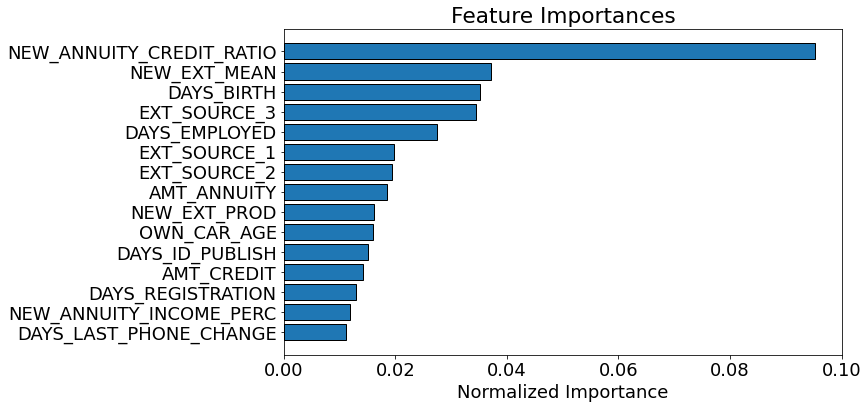

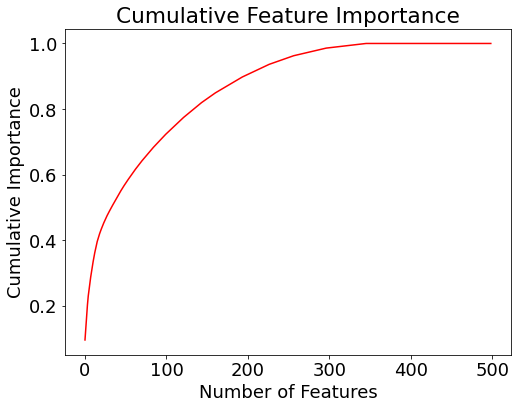

197 features required for 0.90 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

https://www.kaggle.com/c/tabular-playground-series-oct-2021/discussion/283885

**Model Prediction including zero feature importance**

In [ ]:
clf_LGBM.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 200)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.53358	valid_0's auc: 0.764853
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.554379	valid_0's auc: 0.765908


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_test,y_test)

DummyClassifier(strategy='most_frequent')

In [ ]:
y_pred_dum=dummy_clf.predict(X_test)
AUROC_dum=roc_auc_score(y_test, y_pred_dum)
#on va le comparer avec notre scorer
AUROC_dum

0.5

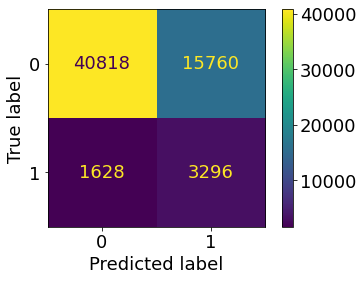

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_LGBM, X_test, y_test) 

In [ ]:
from sklearn import model_selection 
from sklearn.model_selection import KFold
# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [ ]:
test_predictions = clf_LGBM.predict_proba(X_test, num_iteration = 10)[:, 1] / k_fold.n_splits

In [ ]:
AUROC_LGBM=roc_auc_score(y_test, test_predictions)
AUROC_LGBM

0.7441262515629057

In [ ]:
y_predX= clf_LGBM.predict(X_test)

In [ ]:
precision_LGBM = accuracy_score(y_test, y_predX)
precision_LGBM

0.7172774869109948

In [ ]:
rappel_LGBM = recall_score(y_test, y_predX)
rappel_LGBM

0.669374492282697

,thr,tpr,fpr
0,1.936372,0.000000,0.000000
1,0.936372,0.000203,0.000000
2,0.933408,0.000609,0.000000
3,0.931026,0.000609,0.000071
4,0.930244,0.000812,0.000071
...,...,...,...
8259,0.053554,0.999594,0.997243
8260,0.053533,0.999797,0.997243
8261,0.046272,0.999797,0.998798
8262,0.046218,1.000000,0.998798


AUC : 0.7659084850661873


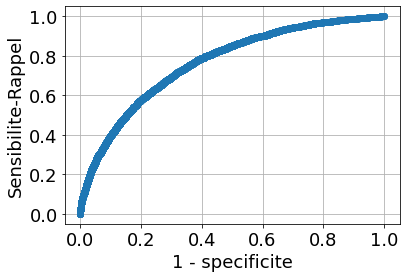

In [ ]:
from sklearn.metrics import roc_auc_score
[fpr, tpr, thr]  = me.roc_curve(y_test, clf_LGBM.predict_proba(X_test)[:, 1])
#1-fpr correspond a la antispecifite pour la vrais specifite 1-valeur
#tpr le rappel , sensibilité
#thr le seuil 

df_roc = pd.DataFrame({'thr': thr, 'tpr': tpr, 'fpr': fpr})
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1 - specificite')
plt.ylabel('Sensibilite-Rappel')
plt.grid()
display(df_roc)
#ceci est notre AUROC qui permet de comparer 
#AUROC_LGBM =roc_auc_score(y_test, clf_LGBM.predict_proba(X_test)[:, 1])

print('AUC : {}'.format(roc_auc_score(y_test, clf_LGBM.predict_proba(X_test)[:, 1])))

In [ ]:
# indice du premier seuil pour lequel
#Taux de faux négatifs + taux de vrais positifs (sensibilité=rappel)=1
#on pose taux de faux negatifs =0.05 (5%)
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensitivity : {:.2f}".format(tpr[idx]))
print("Specificity : {:.2f}".format(1-fpr[idx]))
print("Threshold : {:.2f}".format(thr[idx]))

Sensitivity : 0.95
Specificity : 0.27
Threshold : 0.23


In [ ]:
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

In [ ]:
f1_score_Lgbm = fbeta_score(y_test, y_predX, beta=1)
f5_score_Lgbm = fbeta_score(y_test, y_predX, beta=5)
f10_score_Lgbm = fbeta_score(y_test, y_predX, beta=10)

In [ ]:
print('f1 score:',f1_score_Lgbm)
print('f5 score:',f5_score_Lgbm)
print('f10 score:',f10_score_Lgbm)

f1 score: 0.2748957464553795
f5 score: 0.6028306930414474
f10 score: 0.6508790590001876


In [ ]:
resultat11=pd.DataFrame({ 'Model': ['LightGBM_without_impute_with_F0'], 'f1': [f1_score_Lgbm*100], 'f5': [f5_score_Lgbm*100], 'f10': [f10_score_Lgbm*100],
                      'AUROC':[AUROC_LGBM*100],'Precision':[precision_LGBM*100],'Recall':[rappel_LGBM*100]})

In [ ]:
resultat11

,Model,f1,f5,f10,AUROC,Precision,Recall
0,LightGBM_without_impute_with_F0,27.489575,60.283069,65.087906,74.412625,71.727749,66.937449


In [ ]:
resultat11.to_csv('/content/drive/MyDrive/p7/data/result_LightGBM_wout_impute_w_0F.csv', index=False)

Let's **remove** the features that have **zero importance** on raw dataset.

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/p7/data/Df_data.csv')

**Spliting**

In [ ]:
X= data.drop(['TARGET','SK_ID_CURR'],axis=1).copy()
y = data['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size = 0.2,random_state= 0)
print('The shape of X_train is', X_train.shape)
print('The shape of X_test is', X_test.shape)
print('The shape of y_train is', y_train.shape)
print('The shape of y_test is', y_test.shape)

The shape of X_train is (246005, 499)
The shape of X_test is (61502, 499)
The shape of y_train is (246005,)
The shape of y_test is (61502,)


In [ ]:
del X,y
gc.collect()

8498

In [ ]:
X_train.head(3)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
239193,1,1,1,0,436500.0,3150000.0,79632.0,0.025164,-12932,-2569.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268315,1,0,0,0,337500.0,760122.0,21033.0,0.010032,-16486,-711.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281929,1,0,0,0,85500.0,315000.0,12006.0,0.028663,-18366,-6730.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X_train.shape[1])

# Create the model with several hyperparameters
clf_LGBM = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [ ]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Train using early stopping
    clf_LGBM.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += clf_LGBM.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.53358	valid_0's auc: 0.764853
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.554379	valid_0's auc: 0.765908
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.53358	valid_0's auc: 0.764853
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.554379	valid_0's auc: 0.765908


In [ ]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head(10)

,feature,importance
81,NEW_ANNUITY_CREDIT_RATIO,323.0
82,NEW_EXT_MEAN,126.0
8,DAYS_BIRTH,119.0
28,EXT_SOURCE_3,117.0
9,DAYS_EMPLOYED,93.0
26,EXT_SOURCE_1,67.0
27,EXT_SOURCE_2,66.0
6,AMT_ANNUITY,63.0
83,NEW_EXT_PROD,55.0
12,OWN_CAR_AGE,54.0


In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(10)

There are 154 features with 0.0 importance


,feature,importance
152,ORGANIZATION_TYPE_Industry: type 1,0.0
151,ORGANIZATION_TYPE_Housing,0.0
149,ORGANIZATION_TYPE_Government,0.0
148,ORGANIZATION_TYPE_Emergency,0.0
146,ORGANIZATION_TYPE_Culture,0.0
144,ORGANIZATION_TYPE_Cleaning,0.0
304,PREV_CNT_PAYMENT_MAX,0.0
142,ORGANIZATION_TYPE_Business Entity Type 2,0.0
141,ORGANIZATION_TYPE_Business Entity Type 1,0.0
249,BURO_CREDIT_ACTIVE_Bad debt_MEAN,0.0


In [ ]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """

    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
        # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

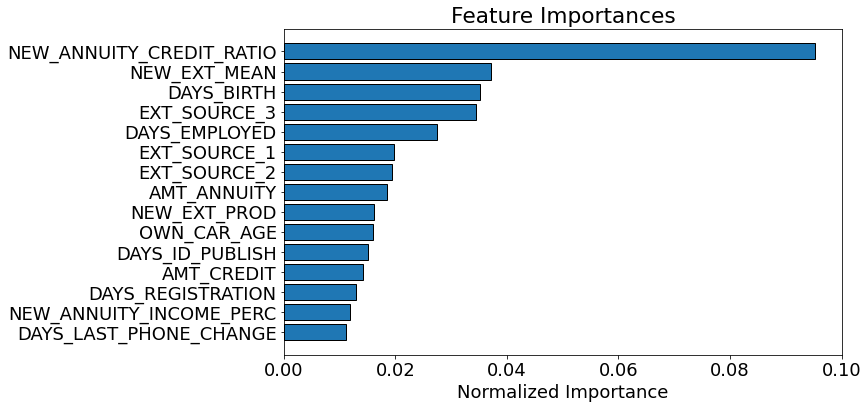

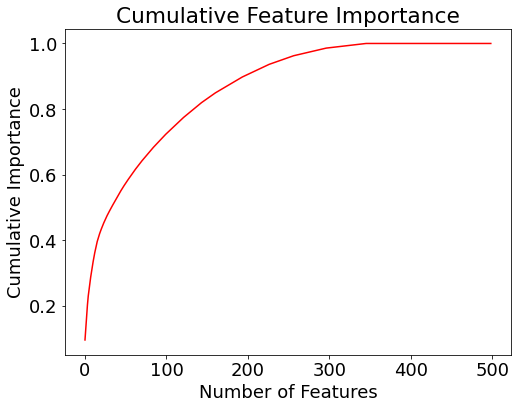

197 features required for 0.90 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [ ]:
X_train = X_train.drop(columns = zero_features)
X_test = X_test.drop(columns = zero_features)

print('Training shape: ', X_train.shape)
print('Testing shape: ', X_test.shape)

Training shape:  (246005, 345)
Testing shape:  (61502, 345)


At this point, we can re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our own form of recursive feature elimination. Since we are repeating work, we should probably put the zero feature importance identification code in a function.

In [ ]:
def identify_zero_importance_features(X, y, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    x_train : dataframe
        Training features
        
    x_test : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X_train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Train using early stopping
        model.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 200)
        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations

            
    feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [ ]:
second_round_zero_features, feature_importances = identify_zero_importance_features(X_train, y_train)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.533092	valid_0's auc: 0.76422
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.547584	valid_0's auc: 0.765982
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.533092	valid_0's auc: 0.76422
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.547584	valid_0's auc: 0.765982

There are 0 features with 0.0 importance


There are now no 0 importance features left (I guess we should have expected this). If we want to remove more features, we will have to start with features that have a non-zero importance. One way we could do this is by retaining enough features to account for a threshold percentage of importance, such as 95%. At this point, let's keep enough features to account for 95% of the importance. Again, this is an arbitrary decision!

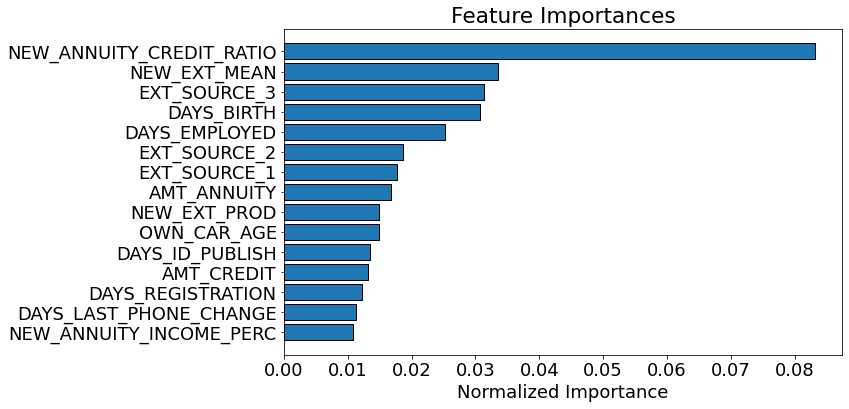

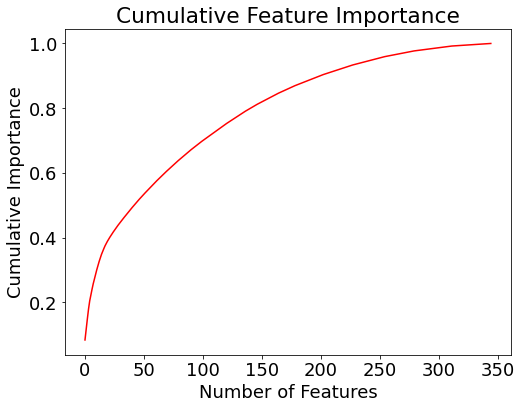

246 features required for 0.95 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

We can keep only the features needed for 95% importance. This step seems to me to have the greatest chance of harming the model's learning ability, so rather than changing the original dataset, we will make smaller copies. Then, we can test both versions of the data to see if the extra feature removal step is worthwhile.

https://www.kaggle.com/prashant111/lightgbm-classifier-in-python

**Model Prediction without zero feature**

In [ ]:
clf_LGBM.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 200)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.533092	valid_0's auc: 0.76422
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.547584	valid_0's auc: 0.765982


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [ ]:
import pickle

pickle.dump(clf_LGBM, open('drive/MyDrive/p7/LGBM_model.sav', 'wb'))

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_test,y_test)

DummyClassifier(strategy='most_frequent')

In [ ]:
y_pred_dum=dummy_clf.predict(X_test)
AUROC_dum=roc_auc_score(y_test, y_pred_dum)
#on va le comparer avec notre scorer
AUROC_dum

0.5

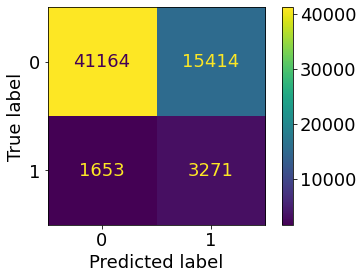

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_LGBM, X_test, y_test) 

In [ ]:
from sklearn import model_selection 
from sklearn.model_selection import KFold
# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [ ]:
test_predictions = clf_LGBM.predict_proba(X_test, num_iteration = 10)[:, 1] / k_fold.n_splits

In [ ]:
AUROC_LGBM=roc_auc_score(y_test, test_predictions)
AUROC_LGBM

0.7441262515629057

In [ ]:
y_predX= clf_LGBM.predict(X_test)

In [ ]:
precision_LGBM = accuracy_score(y_test, y_predX)
precision_LGBM

0.7224968293714026

In [ ]:
rappel_LGBM = recall_score(y_test, y_predX)
rappel_LGBM

0.6642973192526401

,thr,tpr,fpr
0,1.945463,0.000000,0.000000
1,0.945463,0.000203,0.000000
2,0.941112,0.000406,0.000000
3,0.938736,0.000406,0.000053
4,0.936910,0.000609,0.000053
...,...,...,...
8211,0.044687,0.999594,0.998215
8212,0.044509,0.999797,0.998215
8213,0.036462,0.999797,0.999328
8214,0.036395,1.000000,0.999328


AUC : 0.765982123727654


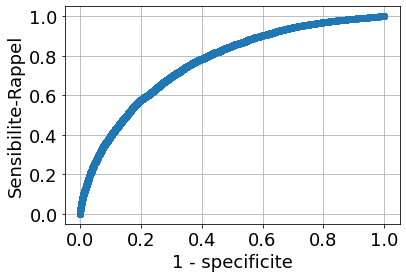

In [ ]:
from sklearn.metrics import roc_auc_score
[fpr, tpr, thr]  = me.roc_curve(y_test, clf_LGBM.predict_proba(X_test)[:, 1])
#1-fpr correspond a la antispecifite pour la vrais specifite 1-valeur
#tpr le rappel , sensibilité
#thr le seuil 

df_roc = pd.DataFrame({'thr': thr, 'tpr': tpr, 'fpr': fpr})
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1 - specificite')
plt.ylabel('Sensibilite-Rappel')
plt.grid()
display(df_roc)
#ceci est notre AUROC qui permet de comparer 
#AUROC_LGBM=roc_auc_score(y_test, clf_LGBM.predict_proba(X_test)[:, 1])

print('AUC : {}'.format(roc_auc_score(y_test, clf_LGBM.predict_proba(X_test)[:, 1])))

In [ ]:
# indice du premier seuil pour lequel
#Taux de faux négatifs + taux de vrais positifs (sensibilité=rappel)=1
#on pose taux de faux negatifs =0.05 (5%)
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensitivity : {:.2f}".format(tpr[idx]))
print("Specificity : {:.2f}".format(1-fpr[idx]))
print("Threshold : {:.2f}".format(thr[idx]))

Sensitivity : 0.95
Specificity : 0.28
Threshold : 0.23


In [ ]:
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

In [ ]:
f1_score_Lgbm = fbeta_score(y_test, y_predX, beta=1)
f5_score_Lgbm = fbeta_score(y_test, y_predX, beta=5)
f10_score_Lgbm = fbeta_score(y_test, y_predX, beta=10)

In [ ]:
print('f1 score:',f1_score_Lgbm)
print('f5 score:',f5_score_Lgbm)
print('f10 score:',f10_score_Lgbm)

f1 score: 0.27709771697234103
f5 score: 0.5998236766935854
f10 score: 0.6464110666523181


In [ ]:
resultat1=pd.DataFrame({'Model': ['LightGBM_without_imputation & 0F'],'f1': [f1_score_Lgbm*100], 'f5': [f5_score_Lgbm*100], 'f10': [f10_score_Lgbm*100],
                      'AUROC':[AUROC_LGBM*100],'Precision':[precision_LGBM*100],'Recall':[rappel_LGBM*100]})

In [ ]:
resultat1

,Model,f1,f5,f10,AUROC,Precision,Recall
0,LightGBM_without_imputation & 0F,27.709772,59.982368,64.641107,74.412625,72.249683,66.429732


In [ ]:
resultat1.to_csv('/content/drive/MyDrive/p7/data/result_LightGBM_wout_impute_0F.csv', index=False)

In [ ]:
res2=pd.read_csv('/content/drive/MyDrive/p7/data/result_RF.csv')

In [ ]:
res1=pd.read_csv('/content/drive/MyDrive/p7/data/result_LightGBM.csv')

In [ ]:
res3=pd.read_csv('/content/drive/MyDrive/p7/data/result_XGB.csv')

In [ ]:
r2= res1.append(res2)
r2= r2.append(res3)


In [ ]:
r2

,Model,f1,f5,f10,AUROC,Precision,Recall,index,Score
0,LightGBM_without_imputation & 0F,27.335366,60.530490,65.448725,74.376075,71.706151,67.345679,NaN,NaN
1,LightGBM_without_impute_with_F0,27.201997,60.418696,65.357351,74.376075,71.550056,67.263374,NaN,NaN
2,LightGBM_with_imputation & 0F,27.052623,60.606276,65.644625,74.009303,71.193964,67.592593,NaN,NaN
3,LightGBM_with_impute_without_0F,26.883910,59.761619,64.654522,74.009303,71.397213,66.543210,NaN,NaN
0,RandomForest,15.816187,70.120124,89.037512,73.588528,16.397476,98.223970,2.0,231.899
0,XG Boost,28.332197,54.605292,57.929509,75.847946,76.062308,0.591784,3.0,78.293


In [ ]:
r

,index,Model,Score,f1,f5,f10,AUROC,Precision,Recall
0,1,LightGBM,88.850,27.123151,59.728048,64.528151,76.032547,71.480293,66.377440
0,2,RandomForest,231.899,15.816187,70.120124,89.037512,73.588528,16.397476,98.223970
0,3,XG Boost,78.293,28.332197,54.605292,57.929509,75.847946,76.062308,0.591784


In [ ]:
r.drop('index', axis=1, inplace=True)
r.drop('Score', axis=1, inplace=True)

In [ ]:
comparaison_score_melt = pd.melt(r.reset_index(), id_vars = ['Model'], value_name = 'Comparaison',\
                                 value_vars=['f1', 'f5','f10','AUROC', 'Precision','Recall'])
#Annulez le pivotement d'un DataFrame du format large au format long, 
#en laissant éventuellement les identifiants définis

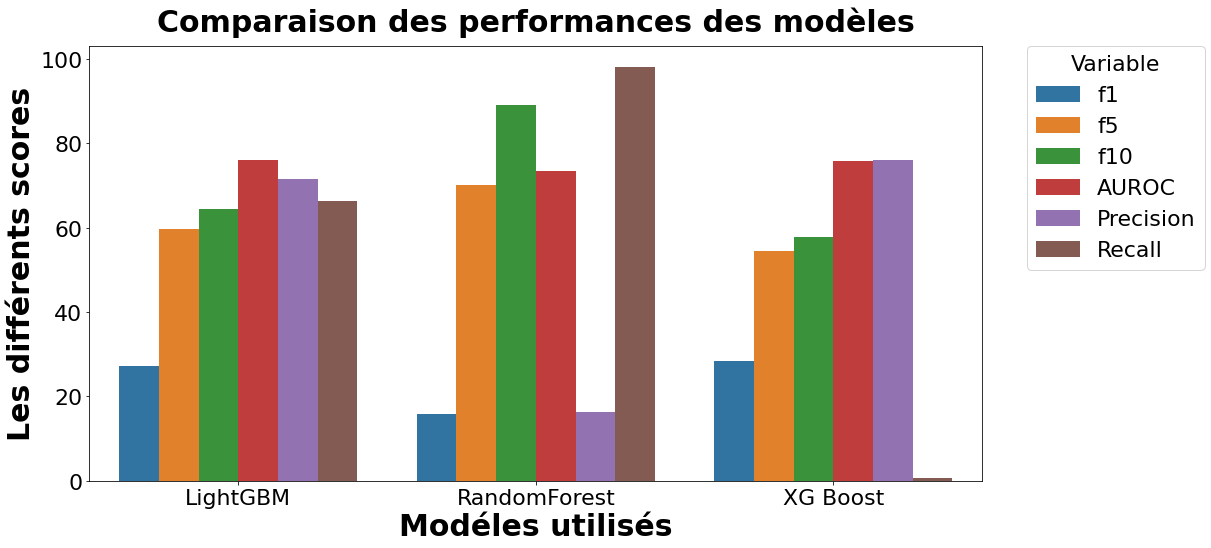

In [ ]:
plt.figure(figsize=(16,8))
sns.barplot(x = comparaison_score_melt['Model'],
            y = comparaison_score_melt['Comparaison'], hue = comparaison_score_melt['variable']);
plt.xlabel('Modéles utilisés',fontsize = 30, fontweight = 'bold')  
plt.ylabel('Les différents scores',fontsize = 30, fontweight = 'bold')          
plt.title('Comparaison des performances des modèles',fontsize = 30, pad = 15, fontweight = 'bold',);
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title= 'Variable')

Selecting LightLGB Model for higher scoring in AUC_COR

In [ ]:
resultat111=pd.read_csv('/content/drive/MyDrive/p7/data/result_LightGBM_with_imput_0F.csv')

In [ ]:
resultat11= pd.read_csv('/content/drive/MyDrive/p7/data/result_LightGBM_wout_impute_w_0F.csv')

In [ ]:
resultat1=pd.read_csv('/content/drive/MyDrive/p7/data/result_LightGBM_wout_impute_0F.csv')

In [ ]:
resultat1111=pd.read_csv('/content/drive/MyDrive/p7/data/LightGBM_w_impute_without_0F.csv')

In [ ]:
r= resultat1.append(resultat11)
r= r.append(resultat111)
r= r.append(resultat1111)

In [ ]:
r

,Model,f1,f5,f10,AUROC,Precision,Recall
0,LightGBM_without_imputation & 0F,27.709772,59.982368,64.641107,74.412625,72.249683,66.429732
0,LightGBM_without_impute_with_F0,27.489575,60.283069,65.087906,74.412625,71.727749,66.937449
0,LightGBM_with_imputation & 0F,27.387926,60.245351,65.076582,74.150787,71.583038,66.937449
0,LightGBM_with_impute_without_0F,27.421572,60.181883,64.986246,74.150787,71.674092,66.835906


In [ ]:
r.to_csv('/content/drive/MyDrive/p7/data/result_LightGBM_diff.csv', index=False)